# Memory Efficiency Comparison: pytorch-cka vs torch-cka

This notebook benchmarks GPU memory management between `pytorch-cka` (this library) and `torch-cka` using CIFAR-10 and ResNet-18 self-comparison.

**Key metric: Retained memory** - Memory that remains allocated after computation should have completed. This reveals whether a library properly deallocates resources.

- `pytorch-cka`: Uses minibatch streaming with explicit `_clear_features()` after each batch
- `torch-cka`: Retains activations in memory after computation

In [1]:
!pip install torch-cka pytorch-cka -q

In [2]:
import gc
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models

from cka import CKA as PytorchCKA
from torch_cka import CKA as TorchCKA

In [3]:
# Check CUDA availability
if not torch.cuda.is_available():
    raise RuntimeError("CUDA is required for GPU memory benchmarking. Please run on a GPU-enabled machine.")

device = torch.device("cuda")
print(f"Using device: {device}")
print(f"GPU: {torch.cuda.get_device_name(0)}")
print(f"Total GPU memory: {torch.cuda.get_device_properties(0).total_memory / (1024**3):.2f} GB")

Using device: cuda
GPU: NVIDIA A100-SXM4-80GB
Total GPU memory: 79.32 GB


In [4]:
def measure_memory_retention(func):
    """Measure memory retained after computation (not deallocated).

    This captures the key difference: pytorch-cka deallocates memory
    after computation, while torch-cka retains it.
    """
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.reset_peak_memory_stats()

    mem_before = torch.cuda.memory_allocated()

    result = func()

    # Force cleanup attempt
    gc.collect()
    torch.cuda.empty_cache()

    mem_after = torch.cuda.memory_allocated()
    peak_mb = torch.cuda.max_memory_allocated() / (1024**2)
    retained_mb = (mem_after - mem_before) / (1024**2)

    return result, peak_mb, retained_mb

In [5]:
def get_resnet18_cifar(num_classes=10):
    """ResNet-18 adapted for CIFAR-10 (smaller input size)."""
    model = models.resnet18(weights=None)
    model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    model.maxpool = nn.Identity()
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

# CIFAR-10 transforms
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

# Download CIFAR-10
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Use a subset for faster benchmarking (1000 samples)
subset_indices = list(range(1000))
subset = Subset(dataset, subset_indices)

print(f"Dataset size: {len(subset)} samples")

100%|██████████| 170M/170M [00:13<00:00, 12.3MB/s]


Dataset size: 1000 samples


In [6]:
def benchmark_pytorch_cka(model, dataloader):
    """Run pytorch-cka self-comparison."""
    with PytorchCKA(model, model, model1_name="ResNet18", device=device) as cka:
        cka.compare(dataloader, progress=False)

def benchmark_torch_cka(model, dataloader):
    """Run torch-cka self-comparison."""
    cka = TorchCKA(
        model, model,
        model1_name="ResNet18",
        model2_name="ResNet18",
        device=device
    )
    with torch.no_grad():
        cka.compare(dataloader, dataloader)

In [7]:
# Batch sizes to test
batch_sizes = [64, 128, 256, 512]

# Results storage
pytorch_cka_peak = []
pytorch_cka_retained = []
torch_cka_peak = []
torch_cka_retained = []

print("Running memory benchmarks...\n")
print(f"{'Batch':<8} {'pytorch-cka':<24} {'torch-cka':<24}")
print(f"{'Size':<8} {'Peak (MB)':<12} {'Retained (MB)':<12} {'Peak (MB)':<12} {'Retained (MB)':<12}")
print("-" * 72)

for batch_size in batch_sizes:
    dataloader = DataLoader(subset, batch_size=batch_size, shuffle=False, num_workers=0)

    # Create fresh model for each test
    model = get_resnet18_cifar().to(device)
    model.eval()

    # Benchmark pytorch-cka
    _, peak1, retained1 = measure_memory_retention(lambda: benchmark_pytorch_cka(model, dataloader))
    pytorch_cka_peak.append(peak1)
    pytorch_cka_retained.append(retained1)

    # Clear and recreate model
    del model
    gc.collect()
    torch.cuda.empty_cache()

    model = get_resnet18_cifar().to(device)
    model.eval()

    # Benchmark torch-cka
    _, peak2, retained2 = measure_memory_retention(lambda: benchmark_torch_cka(model, dataloader))
    torch_cka_peak.append(peak2)
    torch_cka_retained.append(retained2)

    print(f"{batch_size:<8} {peak1:<12.2f} {retained1:<12.2f} {peak2:<12.2f} {retained2:<12.2f}")

    # Cleanup
    del model
    gc.collect()
    torch.cuda.empty_cache()

Running memory benchmarks...

Batch    pytorch-cka              torch-cka               
Size     Peak (MB)    Retained (MB) Peak (MB)    Retained (MB)
------------------------------------------------------------------------


/usr/local/lib/python3.12/dist-packages/torch_cka/cka.py:51: UserWarning: Both model have identical names - ResNet18. It may cause confusion when interpreting the results. Consider giving unique names to the models :)
  warn(f"Both model have identical names - {self.model2_info['Name']}. " \
| Comparing features |: 100%|██████████| 16/16 [01:07<00:00,  4.24s/it]


64       367.57       9.12         387.35       197.08      


| Comparing features |: 100%|██████████| 8/8 [00:35<00:00,  4.41s/it]


128      673.32       0.00         719.83       489.71      


| Comparing features |: 100%|██████████| 4/4 [00:24<00:00,  6.19s/it]


256      1306.60      0.00         1384.71      1090.96     


| Comparing features |: 100%|██████████| 2/2 [00:19<00:00,  9.56s/it]


512      2664.05      0.00         2715.71      2289.22     


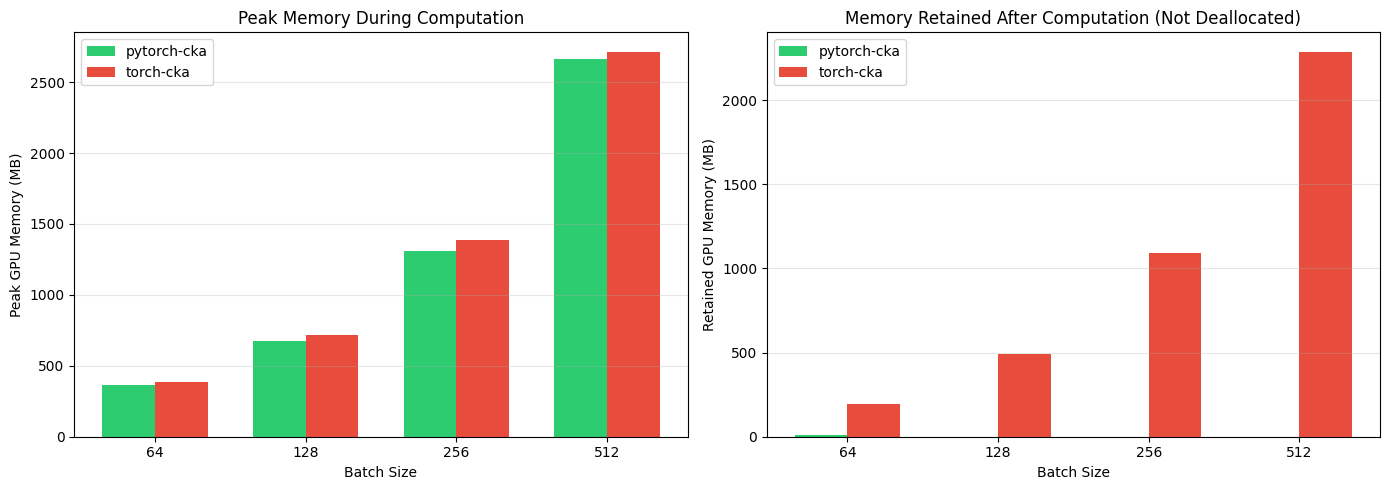

In [9]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

x = np.arange(len(batch_sizes))
width = 0.35

# Left: Peak memory comparison
ax1 = axes[0]
ax1.bar(x - width/2, pytorch_cka_peak, width, label='pytorch-cka', color='#2ecc71')
ax1.bar(x + width/2, torch_cka_peak, width, label='torch-cka', color='#e74c3c')
ax1.set_xlabel('Batch Size')
ax1.set_ylabel('Peak GPU Memory (MB)')
ax1.set_title('Peak Memory During Computation')
ax1.set_xticks(x)
ax1.set_xticklabels(batch_sizes)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Right: Retained memory comparison (the key metric)
ax2 = axes[1]
ax2.bar(x - width/2, pytorch_cka_retained, width, label='pytorch-cka', color='#2ecc71')
ax2.bar(x + width/2, torch_cka_retained, width, label='torch-cka', color='#e74c3c')
ax2.set_xlabel('Batch Size')
ax2.set_ylabel('Retained GPU Memory (MB)')
ax2.set_title('Memory Retained After Computation (Not Deallocated)')
ax2.set_xticks(x)
ax2.set_xticklabels(batch_sizes)
ax2.legend()
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
print("=" * 60)
print("SUMMARY: Memory Efficiency Results")
print("=" * 60)

avg_pytorch_retained = np.mean(pytorch_cka_retained)
avg_torch_retained = np.mean(torch_cka_retained)
avg_pytorch_peak = np.mean(pytorch_cka_peak)
avg_torch_peak = np.mean(torch_cka_peak)

print("\n1. RETAINED MEMORY (not deallocated after computation)")
print("-" * 60)
print(f"   pytorch-cka: {avg_pytorch_retained:.2f} MB (properly deallocates)")
print(f"   torch-cka:   {avg_torch_retained:.2f} MB (retains memory)")
if avg_pytorch_retained > 0:
    print(f"   Ratio: torch-cka retains {avg_torch_retained / max(avg_pytorch_retained, 0.01):.1f}x more memory")

print("\n2. PEAK MEMORY (during computation)")
print("-" * 60)
print(f"   pytorch-cka: {avg_pytorch_peak:.2f} MB")
print(f"   torch-cka:   {avg_torch_peak:.2f} MB")

print("\n3. DETAILED RESULTS BY BATCH SIZE")
print("-" * 60)
print(f"{'Batch':<8} {'pytorch-cka':<24} {'torch-cka':<24}")
print(f"{'Size':<8} {'Peak':<12} {'Retained':<12} {'Peak':<12} {'Retained':<12}")
for i, bs in enumerate(batch_sizes):
    print(f"{bs:<8} {pytorch_cka_peak[i]:<12.2f} {pytorch_cka_retained[i]:<12.2f} "
          f"{torch_cka_peak[i]:<12.2f} {torch_cka_retained[i]:<12.2f}")

print("\n" + "=" * 60)
print("CONCLUSION: pytorch-cka properly deallocates GPU memory after")
print("computation, while torch-cka retains activations in memory.")
print("=" * 60)

SUMMARY: Memory Efficiency Results

1. RETAINED MEMORY (not deallocated after computation)
------------------------------------------------------------
   pytorch-cka: 2.28 MB (properly deallocates)
   torch-cka:   1016.74 MB (retains memory)
   Ratio: torch-cka retains 445.7x more memory

2. PEAK MEMORY (during computation)
------------------------------------------------------------
   pytorch-cka: 1252.89 MB
   torch-cka:   1301.90 MB

3. DETAILED RESULTS BY BATCH SIZE
------------------------------------------------------------
Batch    pytorch-cka              torch-cka               
Size     Peak         Retained     Peak         Retained    
64       367.57       9.12         387.35       197.08      
128      673.32       0.00         719.83       489.71      
256      1306.60      0.00         1384.71      1090.96     
512      2664.05      0.00         2715.71      2289.22     

CONCLUSION: pytorch-cka properly deallocates GPU memory after
computation, while torch-cka retain